# Normal Sun Mode 2016:324 analysis

### __Content__

1. __Star acquisition before entering the NSM__

1. __Attitude offset from the planned direction__

### __Summary__

* At the start of the 324:20:20z comm Chandra was observed to be in Normal Sun Mode. The OBC error-log dump indicated the NSM entry occurred at 12:59:32z, DOY 324.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import Ska.engarchive.fetch as fetch
import Ska.quatutil as quatutil
from Ska.Matplotlib import plot_cxctime
from Chandra.Time import DateTime
from chandra_aca.plot import plot_stars
from Quaternion import Quat
from kadi import events
from itertools import izip, count
import agasc

### 1. Star acquisition before entering the NSM

At 2016:234:12:56:57 (~2 min before NSM) Chandra acquired 6 stars.

<img src='NSM_2016_324_12_56_58.png'>

Below there is a sequence of events that happened over the next ~2-3 min. At ~2016:234:12:58:30 there were no stars acquired in any of the slots.

<img src='NSM_2016_324_12_57_01.png'>

<img src='NSM_2016_324_12_57_06.png'>

<img src='NSM_2016_324_12_57_19.png'>

A snapshot of ACA slots immediately before the NSM:

<img src='NSM_2016_324_12_59_42.png'>

In [2]:
# Approximate time of the star acquisition before the BSH
tstart = '2016:324:12:54:00.000'
tstop = '2016:324:13:00:00.000'

In [3]:
keys = ['aoacmag', 'aoacyan', 'aoaczan']
slots = range(8)

In [4]:
def get_telem(slots, tstart, tstop):
    msids = []
    for slot in slots:
        for key in keys:
            msids.append(key + '{}'.format(slot))
    telem = fetch.MSIDset(msids, start=DateTime(tstart).date, stop=DateTime(tstop).date)
    return telem

In [5]:
telem = get_telem(slots, tstart, tstop)

In [6]:
doy = '2016:324'

# Time ranges for which the mean values are computed, vertical dashed lines
#slot_mean_times = {'start0': ['12:55:30'], 'stop0': ['12:56:47'],
#                   'start1': ['12:57:06'], 'stop1': ['12:58:20'],
#                   'start2': ['12:55:15'], 'stop2': ['12:56:50'],
#                   'start3': ['12:55:17'], 'stop3': ['12:57:07'],
#                   'start4': ['12:55:17'], 'stop4': ['12:57:07'],
#                   'start5': ['12:55:30'], 'stop5': ['12:57:07'],
#                   'start6': ['12:59:02'], 'stop6': ['12:59:37'],
#                   'start7': ['12:54:57'], 'stop7': ['12:56:50'],
#                   }

slot_mean_times = {'start0': ['12:55:30', '12:59:00'], 'stop0': ['12:56:47', '12:59:35'],
                   'start1': ['12:57:06', '12:59:00'], 'stop1': ['12:58:20', '12:59:35'],
                   'start2': ['12:55:15', '12:59:00'], 'stop2': ['12:56:50', '12:59:35'],
                   'start3': ['12:55:17', '12:55:17'], 'stop3': ['12:57:07', '12:57:07'],
                   'start4': ['12:55:17', '12:59:00'], 'stop4': ['12:57:07', '12:59:35'],
                   'start5': ['12:55:30', '12:59:00'], 'stop5': ['12:57:07', '12:59:35'],
                   'start6': ['12:59:00', '12:59:00'], 'stop6': ['12:59:35', '12:59:35'],
                   'start7': ['12:54:57', '12:59:00'], 'stop7': ['12:56:50', '12:59:35'],
                   }

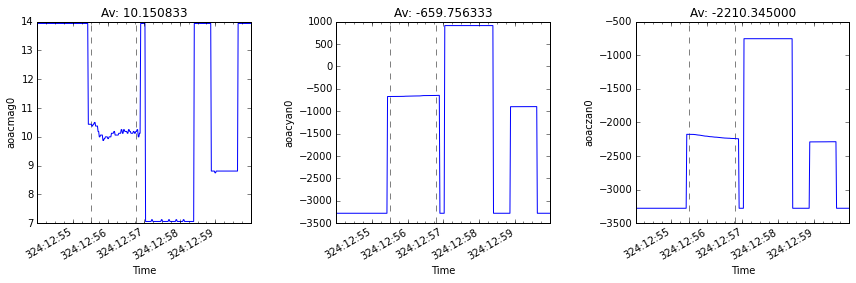

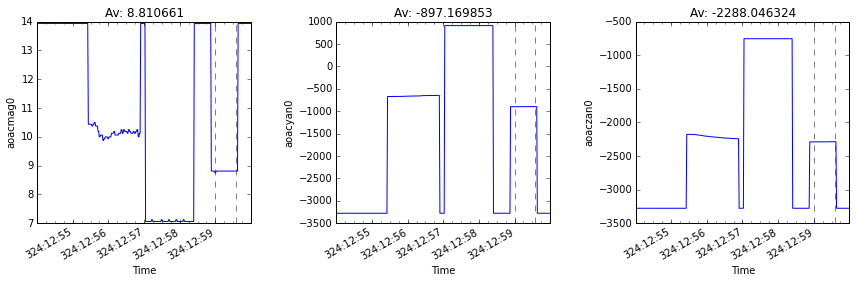

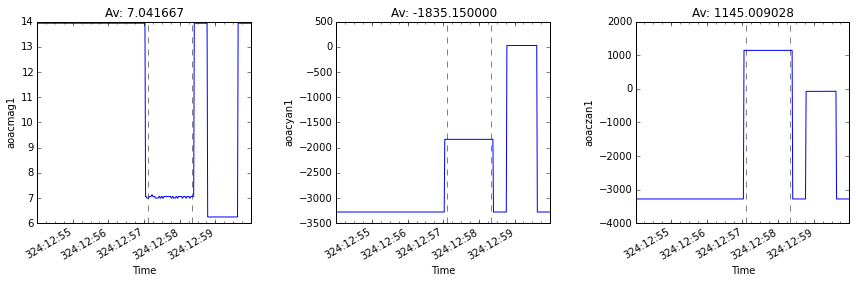

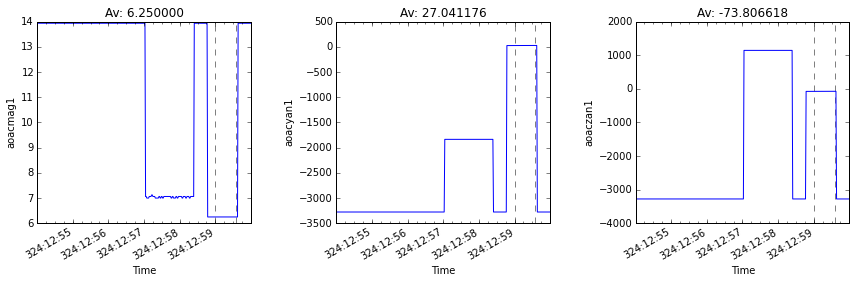

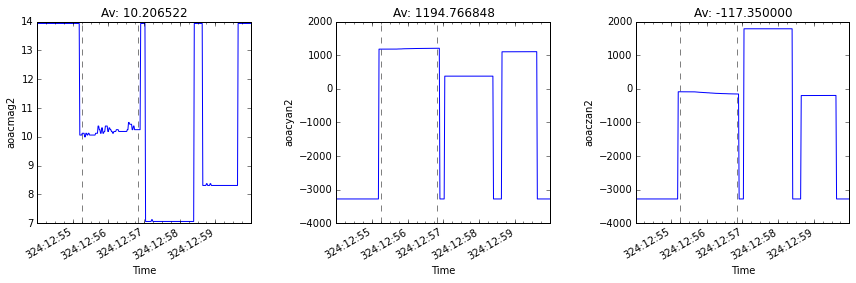

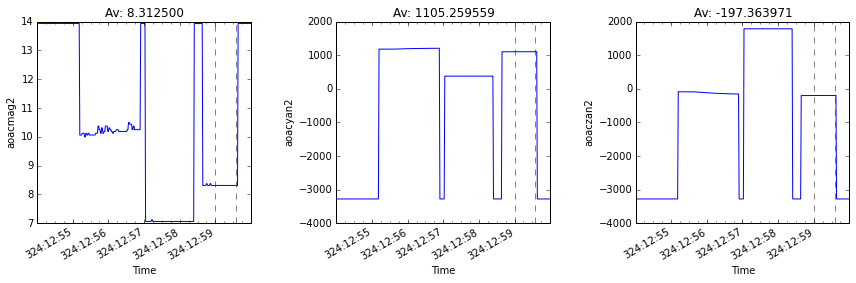

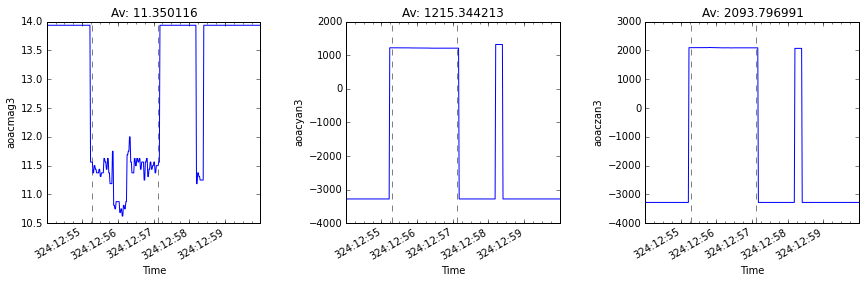

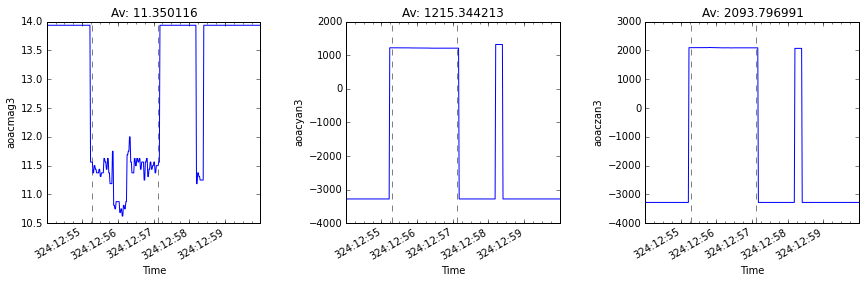

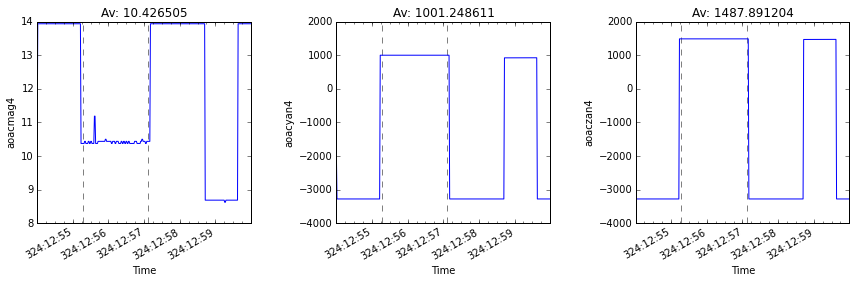

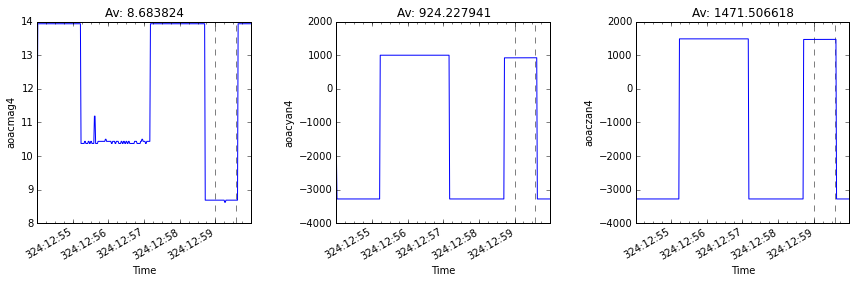

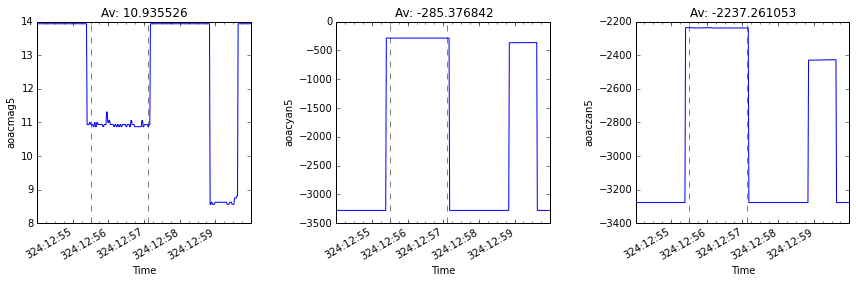

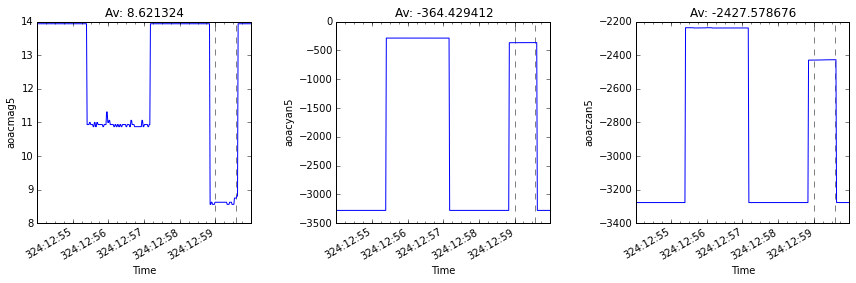

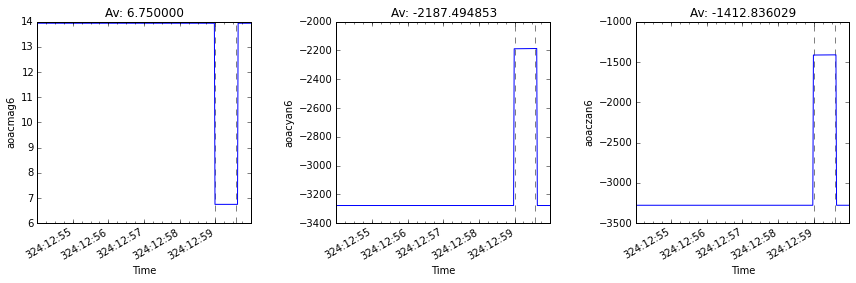

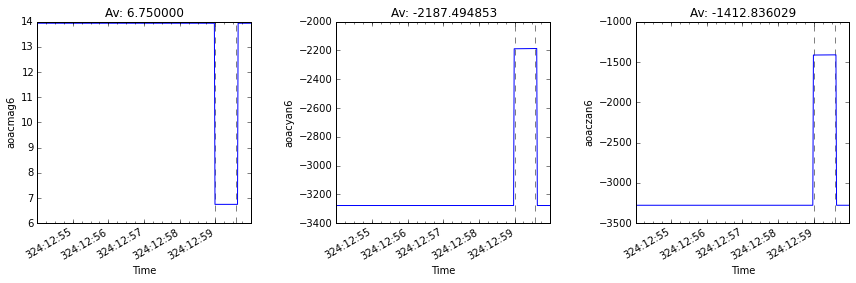

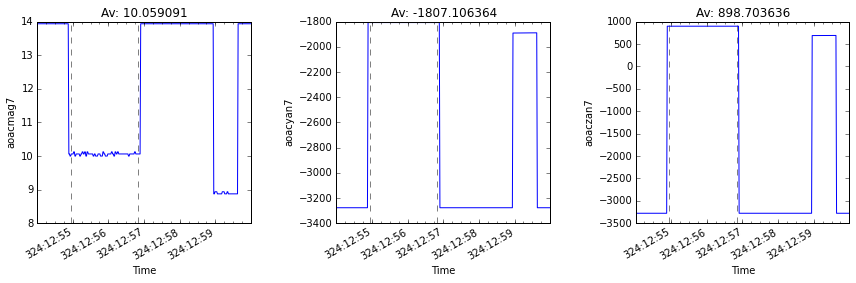

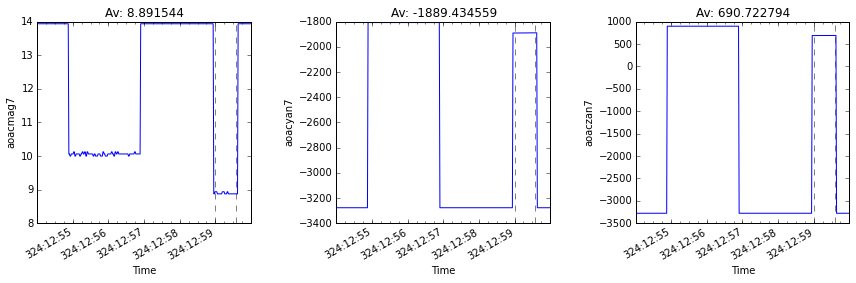

In [7]:
averages = []
rows = []
for slot in slots:
    for tt in [0, 1]:
        row = {}
        start = '{}:{}.000'.format(doy, slot_mean_times['start{}'.format(slot)][tt])
        stop = '{}:{}.000'.format(doy, slot_mean_times['stop{}'.format(slot)][tt])
        plt.figure(figsize=(12, 4))
        for index, key in enumerate(keys):
            msid = key + '{}'.format(slot)
            times_mean = (telem[msid].times > DateTime(start).secs) & (telem[msid].times < DateTime(stop).secs)
            row['slot'] = slot
            average = telem[msid].vals[times_mean].mean()
            row[key] = average
            averages.append(average) 
            # Plot
            plt.subplot(1, 3, index + 1)
            plot_cxctime(telem[msid].times, telem[msid].vals)
            plt.ylabel(msid)
            plt.xlabel("Time")
            plt.title("Av: {0:0f}".format(average))
            plt.vlines(DateTime([start, stop]).plotdate, plt.ylim()[0], plt.ylim()[1],
                       color='gray', linestyle='dashed')
        
        plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.4)
    
        rows.append(row)

In [8]:
t = Table(rows)

print t['slot', 'aoacyan', 'aoaczan', 'aoacmag' ]

slot    aoacyan        aoaczan     aoacmag
---- -------------- -------------- -------
   0 -659.756333333      -2210.345 10.1508
   0 -897.169852941 -2288.04632353 8.81066
   1       -1835.15  1145.00902778 7.04167
   1  27.0411764706 -73.8066176471    6.25
   2  1194.76684783        -117.35 10.2065
   2  1105.25955882 -197.363970588  8.3125
   3  1215.34421296  2093.79699074 11.3501
   3  1215.34421296  2093.79699074 11.3501
   4  1001.24861111   1487.8912037 10.4265
   4  924.227941176  1471.50661765 8.68382
   5 -285.376842105 -2237.26105263 10.9355
   5 -364.429411765 -2427.57867647 8.62132
   6 -2187.49485294 -1412.83602941    6.75
   6 -2187.49485294 -1412.83602941    6.75
   7 -1807.10636364  898.703636364 10.0591
   7 -1889.43455882  690.722794118 8.89154


### 2. Attitude offset from the planned direction

In [9]:
#http://kadi.cfa.harvard.edu/find_attitude/
#
# Take the second entry for each slot (except slot 3, ignore slot 3)
#
#slot yag zag mag
#0 -897.169852941 -2288.04632353 8.81066
#1  27.0411764706 -73.8066176471    6.25
#2  1105.25955882 -197.363970588  8.3125
#4  924.227941176  1471.50661765 8.68382
#5 -364.429411765 -2427.57867647 8.62132
#6 -2187.49485294 -1412.83602941    6.75
#7 -1889.43455882  690.722794118 8.89154
#
#Attitude solution
#
#RA=79.0593754872
#Dec=34.2952547304
#Roll=121.99536912
#
#Q1=0.735572563702
#Q2=0.421663082603
#Q3=0.493763651037
#Q4=0.193211555588
#
#  
# Star match summary and residuals 
#
#slot      YAG            ZAG       MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id
#---- -------------- -------------- ------- -------- ----- -------- ----- ---- ----------
#   0 -897.169852941 -2288.04632353 8.81066  -897.68  0.51 -2288.50  0.46 0.68  314322792
#   1  27.0411764706 -73.8066176471    6.25    27.17 -0.13   -73.85  0.05 0.14  314317808
#   2  1105.25955882 -197.363970588  8.3125  1105.52 -0.26  -197.33 -0.03 0.26  314313576
#   4  924.227941176  1471.50661765 8.68382   924.66 -0.43  1472.13 -0.62 0.75  314189096
#   5 -364.429411765 -2427.57867647 8.62132  -364.31 -0.12 -2427.70  0.12 0.17  314317160
#   6 -2187.49485294 -1412.83602941    6.75 -2187.51  0.01 -1413.03  0.20 0.20  314318832
#   7 -1889.43455882  690.722794118 8.89154 -1889.85  0.41   690.89 -0.17 0.45  313800960

# true attitude estimated based on the stars available before the BSH
RA_true = 79.0593754872
DEC_true = 34.2952547304
ROLL_true = 121.99536912
q_true = Quat((RA_true, DEC_true, ROLL_true))

In [11]:
av = np.array(averages).reshape(3, 16, order='F')

# ra, dec of the stars acquired before the BSH
yag = (av[1] * u.arcsec).to("deg").value
zag = (av[2] * u.arcsec).to("deg").value
ra, dec = quatutil.yagzag2radec(yag, zag, q_true) # using quat corresponding to the true attitute

# search radius
radius = (100. * u.arcsec).to('deg').value

for idx in range(8):
    cat = agasc.agasc.get_agasc_cone(ra=ra[idx], dec=dec[idx], radius=radius, date='2016:324')
    print 'Slot {}, magn = {:.3f}, yag = {:.0f}, zag = {:.0f}'.format(idx, av[0][idx], av[1][idx], av[2][idx])
    if len(cat)==0:
        print
        continue
    dists = []
    for cc in cat:
        dist = (agasc.agasc.sphere_dist(ra[idx], dec[idx], cc['RA'], cc['DEC']) * u.deg).to('arcsec')
        dists.append(dist.value)
    cat['DIST'] = dists
    cat['DIST'].format = '%.1f'
    print cat['AGASC_ID', 'RA', 'DEC', 'MAG_ACA', 'DIST']
    print

Slot 0, magn = 10.151, yag = -660, zag = -2210
 AGASC_ID      RA        DEC     MAG_ACA DIST
--------- ----------- ---------- ------- ----
314321072 79.81579063 34.4746967 10.4454 47.5

Slot 1, magn = 8.811, yag = -897, zag = -2288
 AGASC_ID      RA         DEC     MAG_ACA DIST
--------- ----------- ----------- ------- ----
314322792 79.87306974 34.41797609 9.04794  0.7

Slot 2, magn = 7.042, yag = -1835, zag = 1145
 AGASC_ID    RA      DEC    MAG_ACA DIST
--------- -------- -------- ------- ----
313802040 79.04116 33.67405  11.715 92.2

Slot 3, magn = 6.250, yag = 27, zag = -74
 AGASC_ID      RA         DEC     MAG_ACA DIST
--------- ----------- ----------- ------- ----
314317808 79.07562112 34.31231789 6.29758  0.6

Slot 4, magn = 10.207, yag = 1195, zag = -117
 AGASC_ID    RA      DEC    MAG_ACA DIST
--------- -------- -------- ------- ----
314317016 78.88745 34.60671   9.835 52.1
314313592 78.86033 34.61444  12.505 93.1

Slot 5, magn = 8.312, yag = 1105, zag = -197
 AGASC_ID      R

In [12]:
#https://icxc.harvard.edu/mp/mplogs/2016/NOV1416/oflsa/starcheck.html#obsid19942
#OBSID: 19942  Ae Aur                 ACIS-I SIM Z offset:1920  (4.83mm) Grating: NONE 
#RA, Dec, Roll (deg):    79.115987    34.287170   121.977376
#Dither: ON  Y_amp= 8.0  Z_amp= 8.0  Y_period=1000.0  Z_period= 707.1
#  Q1,Q2,Q3,Q4: 0.73532705  0.42198566  0.49388627  0.19312839
#  MANVR: Angle=  95.01 deg  Duration= 1927 sec  Slew err= 59.5 arcsec
starcheck_catalog_dat = """
idx slot   id      type size   mag     maxmag yang   zang  sz what halfw
 1  0           1   FID  8x8   7.000   8.000    919   -744   1   1   25          
 2  1           5   FID  8x8   7.000   8.000  -1828   1153   1   1   25          
 3  2           6   FID  8x8   7.000   8.000    385   1797   1   1   25          
 4  3   314186320   BOT  6x6   9.048  10.547   1321   2055  13   1   85          
 5  4   314189096   BOT  6x6   8.793  10.297   1039   1599  20   1  120          
 6  5   314317160   BOT  6x6   8.693  10.203   -250  -2300  20   1  120          
 7  6   314318832   BOT  6x6   6.755   8.266  -2073  -1284  20   1  120
 8  7   314321208   GUI  6x6   7.923   9.594  -2095  -1203   1   1   25          
 9  7   313800960   ACQ  6x6   8.921  10.422  -1775    818  20   1  120          
10  0   314322792   ACQ  6x6   9.048  10.547   -784  -2160  20   1  120          
11  1   314317808   ACQ  6x6   6.298   7.797    141     53  20   1  120  
12  2   314313576   ACQ  6x6   8.440   9.938   1219    -70  20   1  120 
"""
starcheck_catalog = ascii.read(starcheck_catalog_dat)

# planned attitude
RA_planned = 79.115987
DEC_planned = 34.287170
ROLL_planned = 121.977376
q_planned = Quat((RA_planned, DEC_planned, ROLL_planned))

In [13]:
offset = (agasc.agasc.sphere_dist(RA_true, DEC_true, RA_planned, DEC_planned) * u.deg).to('arcsec')
print 'Offset: {0:.1f}'.format(offset)

Offset: 170.9 arcsec


In [15]:
dq = q_planned.dq(q_true)
print(dq.roll * 3600, dq.pitch * 3600, dq.yaw * 3600)

(1295949.9184562871, -127.38228683796987, 113.8941879330622)
